### Tabular Dataset
For my tabular dataset, I will be using data from the four IRAC bands (3.6, 4.5, 5.8, and 8 $\mu$m) to classify each object. This data comes from Cornu and Montillaud (2021) (https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/647/A116) and includes Spitzer data of the Orion and NGC 2264 star forming regions. 

Briefly: Young Stellar Objects (YSOs) are stars that have not yet started burning hydrogen. They are split into different classes depending on their envelope to protostar ratio, with Class 0 having the greatest envelope, and Class III no longer having an envelope. Due to how obscured both Class 0 and I are they are very difficult to separate, however they are clearly distinctive from Class II and III. Thus, it is my aim to classify, the different classes of these YSOs. If time permits, I will attempt to classify them all, but my preliminary plan is to merely train the neural network to separate Classes I and II from the whole. Due to the different ratios of envelope to protostar, each class appears differently in spectroscopy, with their spectral energy distributions shown below. Because of this distinction, the difference in fluxes between our IRAC bands are able to determine which class the data comes from. 

*Goal*: Class I, Class II, Other classification

*Input*: IRAC band data and errors

In [1]:
#Import pandas to hold the data
import pandas as pd
#import matplotlib to plot the data
import matplotlib.pyplot as plt
#import numpy to for operations
import numpy as np
# Import a model, for normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# Import all necessary files to deal with images
from PIL import Image
from os import listdir # to iterate through a directory of images
from matplotlib import image
import PIL

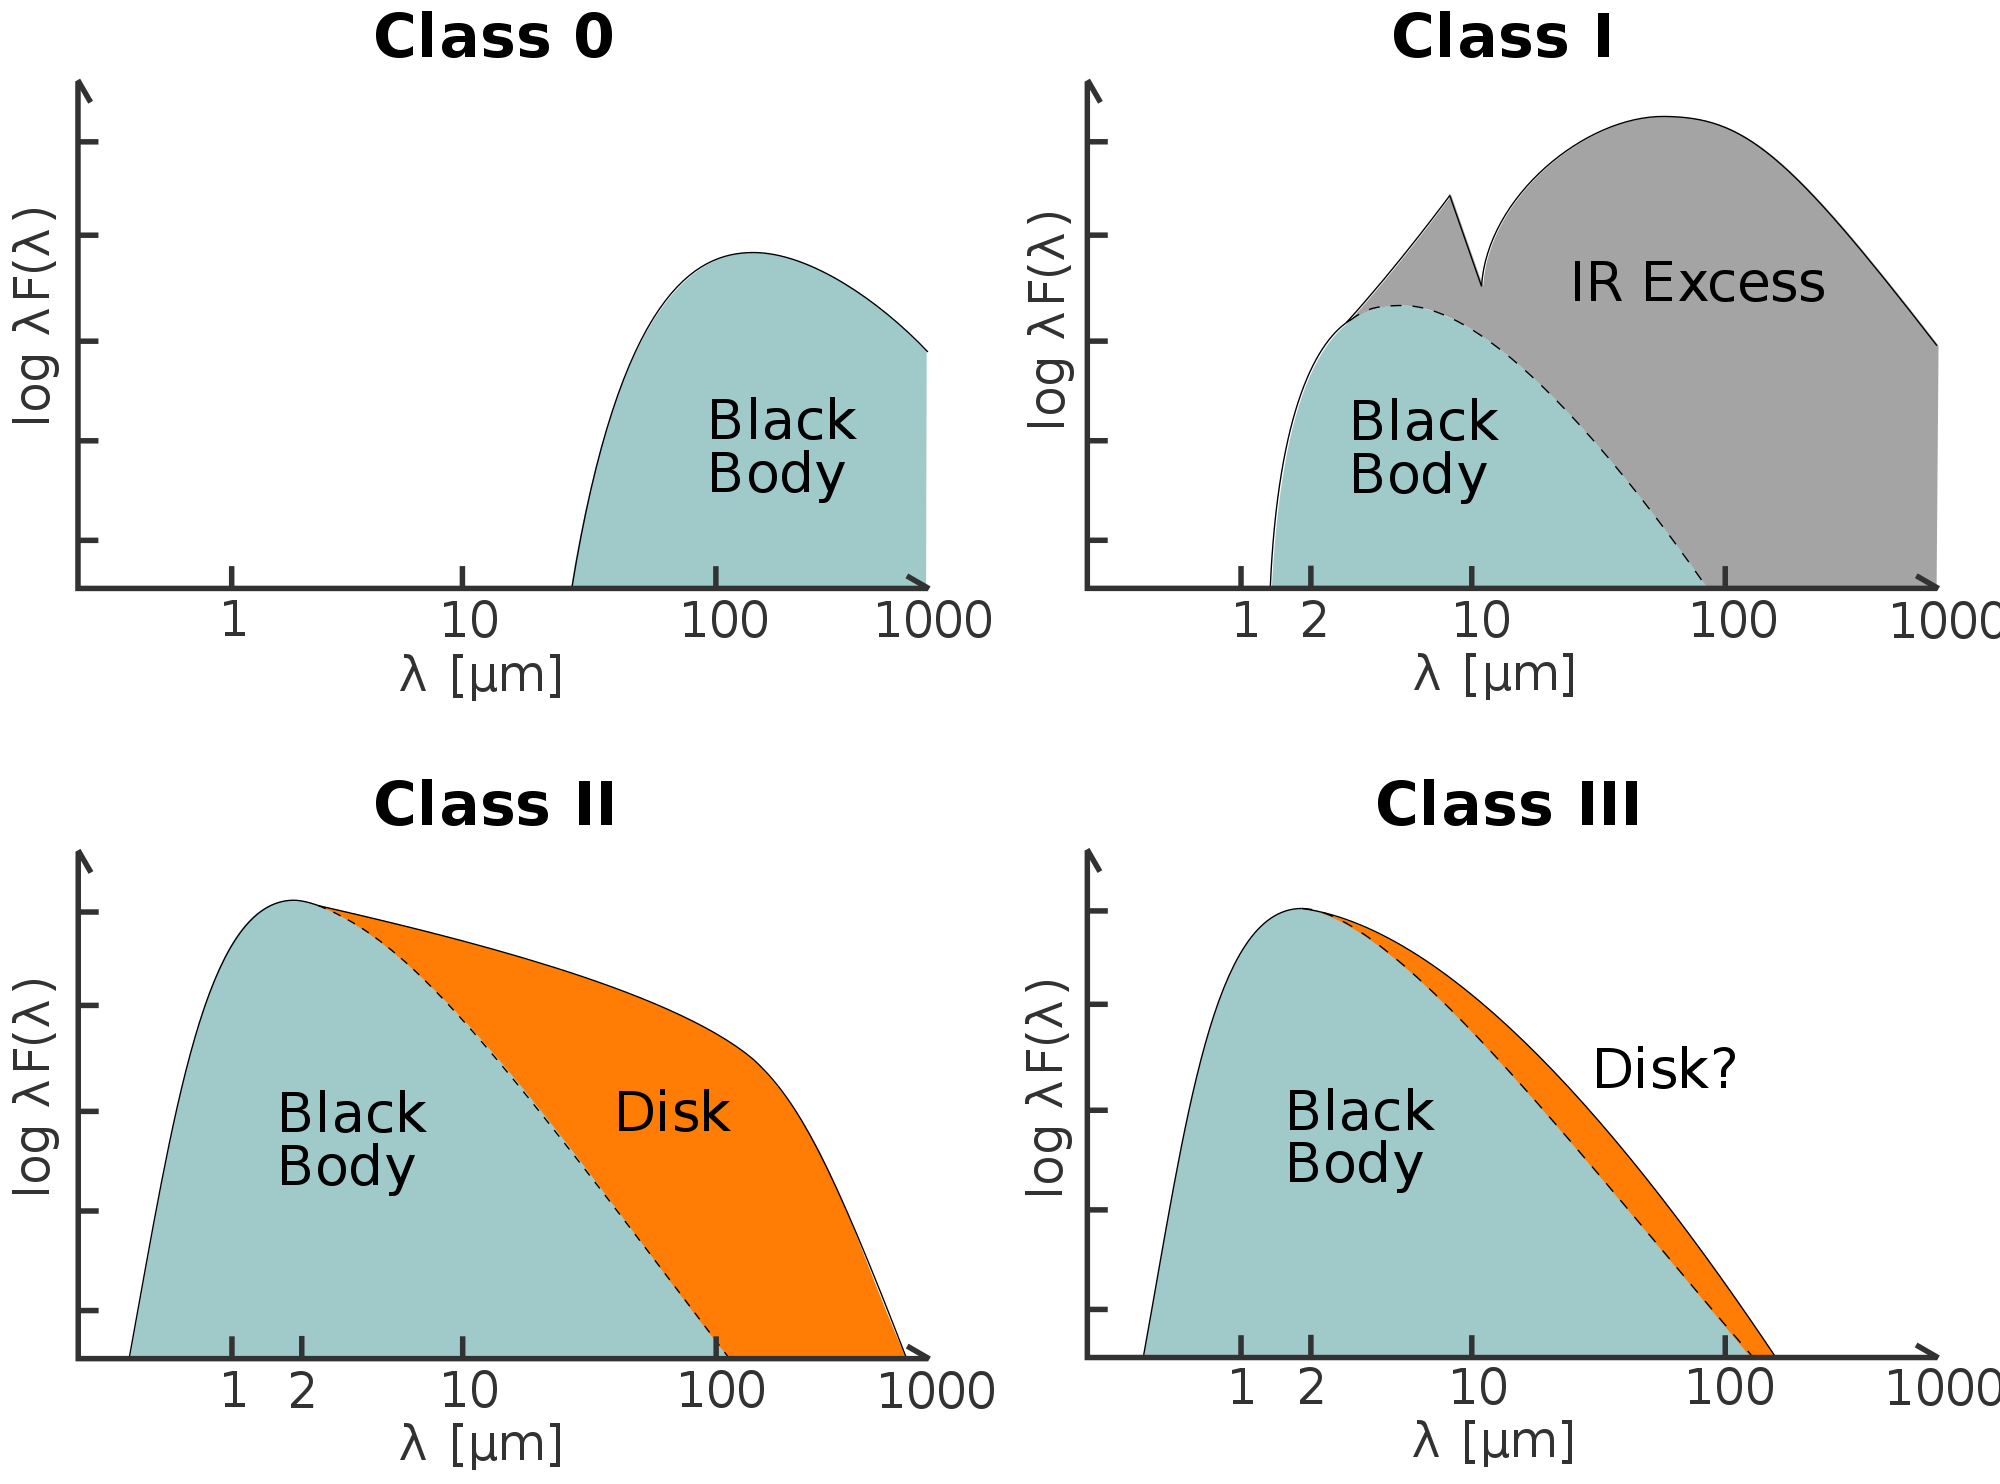

In [3]:
# Tabular dataset

#Take in data
HEAD = ["3.6","d_3.6","4.5","d_4.5","5.8","d_5.8","8","d_8","24","d_24","target","pred","P(CI)","P(CII)","P(Other)"]
DataClass = pd.read_csv("catalog.csv",names = HEAD,engine="python",comment='#')
DataClass.head()

,3.6,d_3.6,4.5,d_4.5,5.8,d_5.8,8,d_8,24,d_24,target,pred,P(CI),P(CII),P(Other)
0,10.32,0.003,10.17,0.003,10.07,0.005,10.03,0.008,,,6,2,0.0,0.000057,0.999943
1,11.62,0.003,11.60,0.004,11.55,0.016,11.56,0.035,,,6,2,0.0,0.000000,1.000000
2,13.38,0.007,13.28,0.011,13.27,0.050,13.78,0.155,,,6,2,0.0,0.000000,1.000000
3,12.52,0.005,12.52,0.006,12.40,0.030,12.41,0.053,,,6,2,0.0,0.000000,1.000000
4,13.71,0.009,13.66,0.013,13.60,0.069,13.67,0.148,,,6,2,0.0,0.000000,1.000000


In [4]:
#Give a concise list of the columns and what kind of data they contain.
DataClass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26903 entries, 0 to 26902
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   3.6       26903 non-null  float64
 1   d_3.6     26903 non-null  float64
 2   4.5       26903 non-null  float64
 3   d_4.5     26903 non-null  float64
 4   5.8       26903 non-null  float64
 5   d_5.8     26903 non-null  float64
 6   8         26903 non-null  float64
 7   d_8       26903 non-null  float64
 8   24        26903 non-null  object 
 9   d_24      26903 non-null  object 
 10  target    26903 non-null  int64  
 11  pred      26903 non-null  int64  
 12  P(CI)     26903 non-null  float64
 13  P(CII)    26903 non-null  float64
 14  P(Other)  26903 non-null  float64
dtypes: float64(11), int64(2), object(2)
memory usage: 3.1+ MB


In [5]:
AllClass = DataClass[["3.6","d_3.6","4.5","d_4.5","5.8","d_5.8","8","d_8","pred"]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febb4919390>,
      dtype=object)

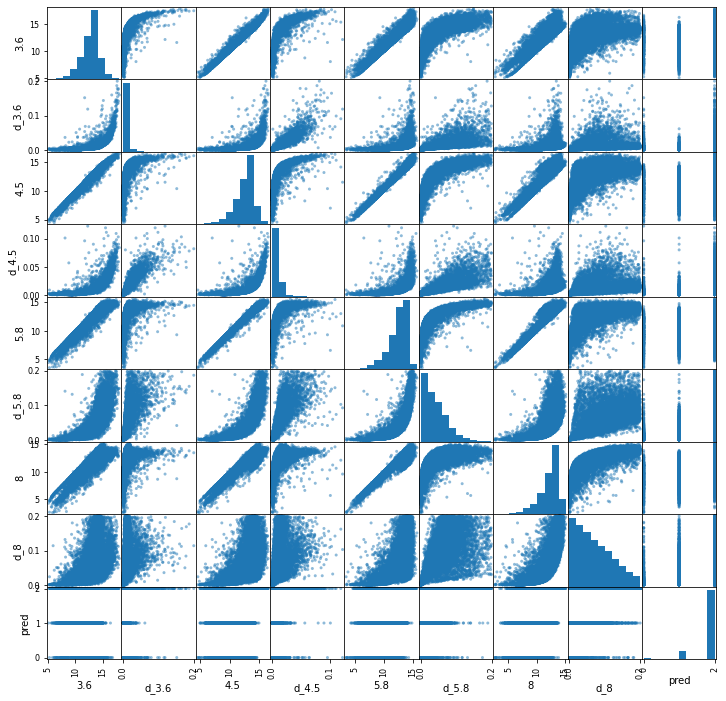

In [6]:
pd.plotting.scatter_matrix(AllClass, figsize=(12,12))

This data was pulled from a previous ML paper (Cornu et al. 2021). The targets were determined through a series of intensive cuts, and resulted in the following classes:
(0): Class I YSOs
(1): Class II YSOs
(2): Class III YSOs
(3): Galaxies
(4): Shocks
(5): PAHs
(6): Stars

These can be further grouped into (0): Class I YSOs, (1): Class II YSOs, (2): Others.

My goal will be to separate Class I and Class II from all other objects based upon the spectroscopic data. Thus all I will need for input data is the spectroscopic data from the four IRAC bands, and the target.

In [7]:
# Define a new dataset which only holds the input data from the four IRAC bands
InputClass = DataClass[["3.6","d_3.6","4.5","d_4.5","5.8","d_5.8","8","d_8"]]

# Define a new dataset which holds only the target data - using the results from 
# Cornu and Montillaud (2021) which are in the "pred column"
TargetClass = DataClass[["pred"]]



print("The shape of the input data is:", InputClass.shape)
print("The shape of the target data is:", TargetClass.shape)

The shape of the input data is: (26903, 8)
The shape of the target data is: (26903, 1)


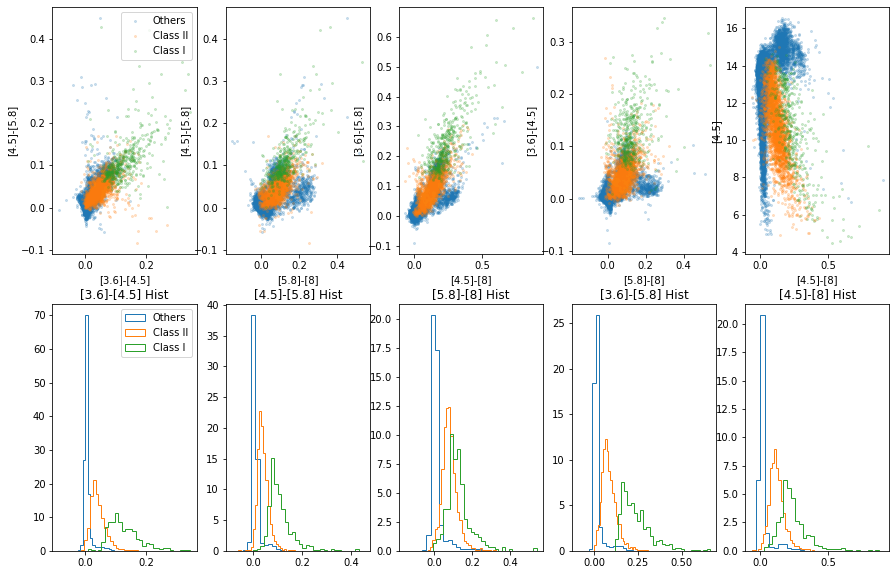

In [8]:
# Το see how this data can be separated, we can plot diagrams of the changes between the bands. 
# Because different classes have different amount of envelope material, they will stand out more in different bands.


#Difference between bands is computed as a logarithm - this gives "colour"
def magdif(lowerband,upperband):
  return 2.5*np.log10(lowerband/upperband)


# Plot each class for the difference between each consecutive band ([3.6]-[4.5] vs [4.5]-[5.8], [4.5]-[5.8] vs [5.8]-[8])
# Define the different classes; defined backwards due to how we want to plot them
classes = ["Others", "Class II", "Class I"] 

# Create plot to hold the different colour-colour diagrams
fig,axs = plt.subplots(2,5,figsize=(15,10))

#iterate over and collect vals for [3.6]-[4.5], [4.5]-[5.8], and [5.8]-[8])
for it,cl in enumerate(classes):
  if it ==0: #Want to have Class I most visible, so others needs to be plotted first, corresponds to a target value of 2
    i=2
  elif it ==2: # it==2 means we're in Class I category, corresponds to target value of 0
    i=0
  elif it==1: # it==1 means we're in Class II category, corresponds to target value of 1
    i=1
  #Define variables to hold the data for each colour difference
  Band1 = []#[3.6]-[4.5]
  Band2 = []#[4.5]-[5.8]
  Band3 = []#[5.8]-[8]
  Band4 = []#[3.6]-[5.8]
  Band5 = []#[4.5]-[8]
  Mag45 =[]#[4.5] on it's own
  for index, tar in TargetClass.iterrows(): #iterate through the target series
    if tar.to_numpy()[0] == i: # Check that the class of the particular target value is the same as the class being iterated through
      Band1.append(magdif(InputClass.to_numpy()[index][0],InputClass.to_numpy()[index][2]))#[3.6]-[4.5]
      Band2.append(magdif(InputClass.to_numpy()[index][2],InputClass.to_numpy()[index][4]))#[4.5]-[5.8]
      Band3.append(magdif(InputClass.to_numpy()[index][4],InputClass.to_numpy()[index][6]))#[5.8]-[8]
      Band4.append(magdif(InputClass.to_numpy()[index][0],InputClass.to_numpy()[index][4]))#[3.6]-[5.8]
      Band5.append(magdif(InputClass.to_numpy()[index][2],InputClass.to_numpy()[index][6]))#[4.5]-[8]
      Mag45.append(InputClass.to_numpy()[index][2]) #[4.5]
  axs[0][0].plot(Band1,Band2,'.',markersize='4',alpha=0.2,label=cl)#[3.6]-[4.5] vs [4.5]-[5.8]
  axs[0][1].plot(Band3,Band2,'.',markersize='4',alpha=0.2,label=cl)#[5.8]-[8] vs [4.5]-[5.8]
  axs[0][2].plot(Band5,Band4,'.',markersize='4',alpha=0.2,label=cl)#[4.5]-[8] vs [3.6]-[5.8]
  axs[0][3].plot(Band3,Band1,'.',markersize='4',alpha=0.2,label=cl)#[5.8]-[8] vs [3.6]-[4.5]
  axs[0][4].plot(Band5,Mag45,'.',markersize='4',alpha=0.2,label=cl)#[4.5]-[8] vs [4.5]
  axs[1][0].hist(Band1,bins=30,density=True,histtype='step',label=cl) # Histogram of [3.6]-[4.5] (each class normalized 1 under the curve)
  axs[1][1].hist(Band2,bins=30,density=True,histtype='step',label=cl) # Histogram of [4.5]-[5.8] (each class normalized 1 under the curve)
  axs[1][2].hist(Band3,bins=30,density=True,histtype='step',label=cl) # Histogram of [5.8]-[8] (each class normalized 1 under the curve)
  axs[1][3].hist(Band4,bins=30,density=True,histtype='step',label=cl) # Histogram of [3.6]-[5.8] (each class normalized 1 under the curve)
  axs[1][4].hist(Band5,bins=30,density=True,histtype='step',label=cl) # Histogram of [4.5]-[8] (each class normalized 1 under the curve)

# Set axes labels
axs[0][0].set_xlabel('[3.6]-[4.5]')
axs[0][0].set_ylabel('[4.5]-[5.8]')
axs[0][1].set_xlabel('[5.8]-[8]')
axs[0][1].set_ylabel('[4.5]-[5.8]')
axs[0][2].set_ylabel('[3.6]-[5.8]')
axs[0][2].set_xlabel('[4.5]-[8]')
axs[0][3].set_ylabel('[3.6]-[4.5]')
axs[0][3].set_xlabel('[5.8]-[8]')
axs[0][2].set_ylabel('[3.6]-[5.8]')
axs[0][2].set_xlabel('[4.5]-[8]')
axs[1][0].set_title('[3.6]-[4.5] Hist')
axs[1][1].set_title('[4.5]-[5.8] Hist')
axs[1][2].set_title('[5.8]-[8] Hist')
axs[1][3].set_title('[3.6]-[5.8] Hist')
axs[1][4].set_title('[4.5]-[8] Hist')
axs[0][4].set_xlabel('[4.5]-[8]')
axs[0][4].set_ylabel('[4.5]')
axs[0][0].legend()
axs[1][0].legend()

### Some Thoughts:

I've been working directly with the fluxes. It may be beneficial to perhaps work with colours/magnitudes instead. Thoughts? These can be added as extra columns too.